In [69]:
import numpy as np
from pandas import read_csv

In [70]:
#lstm_data = np.genfromtxt('./sample_data/lstm.csv', delimiter=',', skip_header=True)
lstm_data = read_csv('lstmshib.csv')
lstm_data = lstm_data.drop(['Date'], axis=1)
print(lstm_data)

        High       Low      Open     Close      Volume  Adj Close  \
0   0.000034  0.000032  0.000034  0.000033   720676202   0.000033   
1   0.000021  0.000020  0.000021  0.000021   421850042   0.000021   
2   0.000026  0.000025  0.000026  0.000025   963213922   0.000025   
3   0.000027  0.000026  0.000026  0.000027   918512393   0.000027   
4   0.000033  0.000032  0.000033  0.000032   717218977   0.000032   
5   0.000022  0.000021  0.000021  0.000022   609855710   0.000022   
6   0.000025  0.000023  0.000025  0.000024   977852640   0.000024   
7   0.000027  0.000026  0.000027  0.000026  1101356399   0.000026   
8   0.000032  0.000029  0.000029  0.000030  2065365631   0.000030   
9   0.000023  0.000021  0.000022  0.000022   660720467   0.000022   
10  0.000028  0.000026  0.000027  0.000027  2032682825   0.000027   
11  0.000031  0.000029  0.000030  0.000030  1558119657   0.000030   
12  0.000022  0.000021  0.000022  0.000022   632243876   0.000022   
13  0.000027  0.000025  0.000027  

In [71]:
lstm_data_X = lstm_data.drop(['Close'], axis=1)
lstm_data_y = lstm_data['Close']

In [72]:
look_back = 5 # how many days to look back
batch_size = 3 # size of batches used when training
n_feat = 6 # number of features 
n_target = 2
n_validation = 6
n_test = 8
n_train = lstm_data_X.shape[0] - n_validation - n_test - 1


In [73]:
lstm_data_X_train = lstm_data_X.iloc[:n_train,:]
lstm_data_X_val = lstm_data_X.iloc[n_train:n_train + n_validation,:]
lstm_data_X_test = lstm_data_X.iloc[n_train + n_validation:n_train + n_validation + n_test,:]

lstm_data_y_train = lstm_data_y.iloc[:n_train]
lstm_data_y_val = lstm_data_y.iloc[n_train:n_train + n_validation]
lstm_data_y_test = lstm_data_y.iloc[n_train + n_validation:n_train + n_validation + n_test]
# Convert to numpy arrays
X_train = lstm_data_X_train.to_numpy()
X_val = lstm_data_X_val.to_numpy()
X_test = lstm_data_X_test.to_numpy()
y_train = lstm_data_y_train.to_numpy()
y_val = lstm_data_y_val.to_numpy()
y_test = lstm_data_y_test.to_numpy()

In [74]:
X_test

array([[2.59999997e-05, 2.40000008e-05, 2.49999994e-05, 1.09935158e+09,
        2.40000008e-05, 1.41458700e-01],
       [2.49999994e-05, 2.40000008e-05, 2.40000008e-05, 4.72902729e+08,
        2.40000008e-05, 2.27658000e-01],
       [2.49999994e-05, 2.30000005e-05, 2.40000008e-05, 1.21708961e+09,
        2.30000005e-05, 1.99485454e-01],
       [2.59999997e-05, 2.40000008e-05, 2.40000008e-05, 7.92774798e+08,
        2.59999997e-05, 1.69029840e-01],
       [2.59999997e-05, 2.30000005e-05, 2.30000005e-05, 1.51395371e+09,
        2.59999997e-05, 1.31502325e-01],
       [2.90000007e-05, 2.49999994e-05, 2.59999997e-05, 3.56160726e+09,
        2.59999997e-05, 1.53586280e-01],
       [2.80000004e-05, 2.59999997e-05, 2.59999997e-05, 2.06383842e+09,
        2.70000000e-05, 1.14973180e-01],
       [2.80000004e-05, 2.59999997e-05, 2.70000000e-05, 1.62991388e+09,
        2.70000000e-05, 1.07060620e-01]])

In [75]:
y_test

array([2.40000008e-05, 2.40000008e-05, 2.30000005e-05, 2.59999997e-05,
       2.59999997e-05, 2.59999997e-05, 2.70000000e-05, 2.70000000e-05])

In [76]:
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [77]:
train_data_gen = TimeseriesGenerator(X_train, y_train, length=look_back, batch_size=batch_size)
val_data_gen = TimeseriesGenerator(X_val, y_val, length=look_back, batch_size=batch_size)
test_data_gen = TimeseriesGenerator(X_test, y_test, length=look_back, batch_size=batch_size)

In [78]:
# check generator dimensions
for i in range(len(train_data_gen)):
    x, y = train_data_gen[i]
    print(x.shape, y.shape)

(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(3, 5, 6) (3,)
(2, 5, 6) (2,)


In [79]:
model_lstm = Sequential()
model_lstm.add(LSTM(32, input_shape=(look_back, n_feat), return_sequences=True))
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 5, 32)             4992      
                                                                 
 dropout_8 (Dropout)         (None, 5, 32)             0         
                                                                 
 lstm_9 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,345
Trainable params: 13,345
Non-trainable params: 0
_________________________________________________________________
None


In [80]:
hist = model_lstm.fit_generator(train_data_gen,
                                        steps_per_epoch=10,
                                        epochs=20,
                                        verbose=1,
                                        validation_data=val_data_gen)

Epoch 1/20


C:\Users\moham\AppData\Local\Temp/ipykernel_1520/192094070.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model_lstm.fit_generator(train_data_gen,


10/10 [==============================] - 4s 85ms/step - loss: 0.0147 - mse: 0.0147 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 2/20
10/10 [==============================] - 0s 11ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0048 - val_mse: 0.0048
Epoch 3/20
10/10 [==============================] - 0s 11ms/step - loss: 0.0110 - mse: 0.0110 - val_loss: 2.3004e-05 - val_mse: 2.3004e-05
Epoch 4/20
10/10 [==============================] - 0s 13ms/step - loss: 0.0069 - mse: 0.0069 - val_loss: 6.7093e-05 - val_mse: 6.7093e-05
Epoch 5/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 3.7165e-05 - val_mse: 3.7165e-05
Epoch 6/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0027 - mse: 0.0027 - val_loss: 5.7373e-06 - val_mse: 5.7373e-06
Epoch 7/20
10/10 [==============================] - 0s 10ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 5.4146e-04 - val_mse: 5.4146e-04
Epoch 8/20
10/10 [==============================] - 0s

In [81]:
pred = model_lstm.predict(test_data_gen)

In [82]:
test_data_gen[0]

(array([[[2.59999997e-05, 2.40000008e-05, 2.49999994e-05, 1.09935158e+09,
          2.40000008e-05, 1.41458700e-01],
         [2.49999994e-05, 2.40000008e-05, 2.40000008e-05, 4.72902729e+08,
          2.40000008e-05, 2.27658000e-01],
         [2.49999994e-05, 2.30000005e-05, 2.40000008e-05, 1.21708961e+09,
          2.30000005e-05, 1.99485454e-01],
         [2.59999997e-05, 2.40000008e-05, 2.40000008e-05, 7.92774798e+08,
          2.59999997e-05, 1.69029840e-01],
         [2.59999997e-05, 2.30000005e-05, 2.30000005e-05, 1.51395371e+09,
          2.59999997e-05, 1.31502325e-01]],
 
        [[2.49999994e-05, 2.40000008e-05, 2.40000008e-05, 4.72902729e+08,
          2.40000008e-05, 2.27658000e-01],
         [2.49999994e-05, 2.30000005e-05, 2.40000008e-05, 1.21708961e+09,
          2.30000005e-05, 1.99485454e-01],
         [2.59999997e-05, 2.40000008e-05, 2.40000008e-05, 7.92774798e+08,
          2.59999997e-05, 1.69029840e-01],
         [2.59999997e-05, 2.30000005e-05, 2.30000005e-05, 1.5

In [83]:
pred

array([[0.00720249],
       [0.00720249],
       [0.00720249]], dtype=float32)

In [84]:
import matplotlib.pyplot as plt

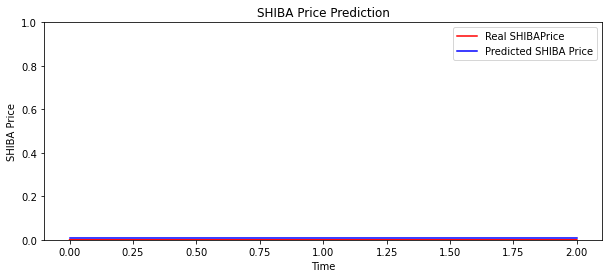

In [85]:
# Visualising the results
plt.figure(figsize=(10,4))
plt.plot(y_test[0:y_test.shape[0]-5], color = 'red', label = 'Real SHIBAPrice')
plt.plot(pred, color = 'blue', label = 'Predicted SHIBA Price')
plt.title('SHIBA Price Prediction')
plt.xlabel('Time')
plt.ylabel('SHIBA Price')
plt.ylim(0,1)
plt.legend()
plt.show()